Johannes M. Halkenhaeusser

Minerva Schools at KGI

CS146 - Prof. Scheffler

Spring 2020


# Data 
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy.stats as sts
from google.colab import files
import pandas as pd
import datetime
import pystan
import sklearn.metrics 
from sklearn.linear_model import LinearRegression
import random as rd
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
full_csv_file = files.upload()

Saving climate_data_noheader.csv to climate_data_noheader.csv


In [0]:
raw_climate = pd.read_csv('climate_data_noheader.csv')

In [0]:
climate = pd.DataFrame(raw_climate)

In [5]:
climate.head()

,Date,co2
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [0]:
climate['Date'] = pd.to_datetime(pd.Series(climate['Date']), format="%Y/%m/%d")


In [0]:
#converting to days since the start of the data set because it is easier to work with. 

day_since_start = []
for day in climate['Date']:
    day_since_start.append((day - climate['Date'][0]).days)
climate['Days'] = day_since_start

In [0]:
#converting back from the day scale 
def convert_back_to_datetime(array):
    actual_dates = []

    for day in array:
        #add the original date back onto it
        
        actual_dates.append(climate['Date'][0] + datetime.timedelta(day))
    return actual_dates

Text(0, 0.5, '$CO_2$ concentration (ppm)')

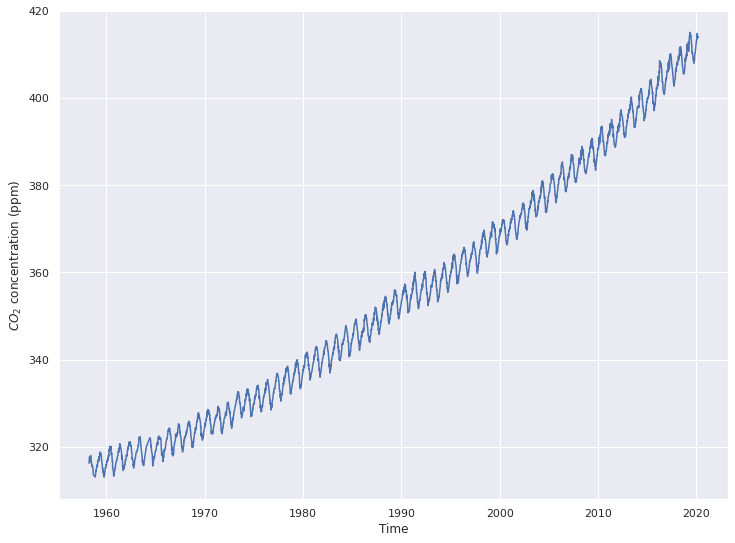

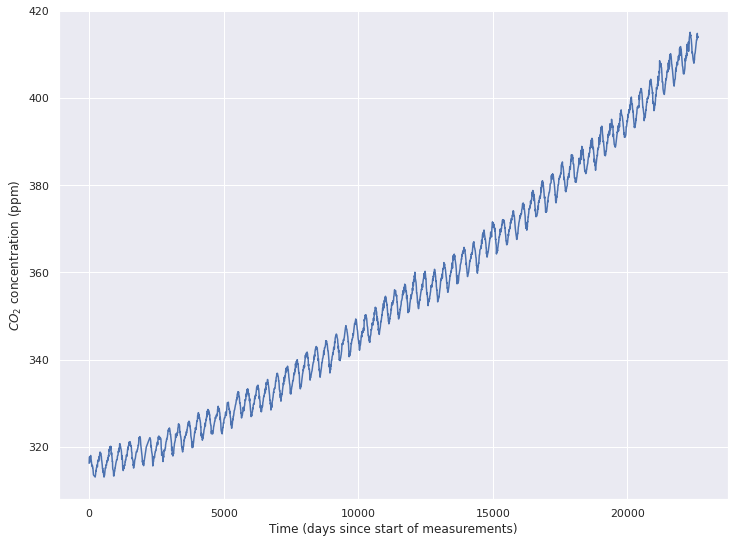

In [9]:
#figure 2
plt.figure(figsize= (12,9))
plt.plot(climate['Date'], climate['co2'])
plt.xlabel('Time')
plt.ylabel('$CO_2$ concentration (ppm)')

plt.figure(figsize= (12,9))
plt.plot(climate['Days'], climate['co2'])
plt.xlabel('Time (days since start of measurements)')
plt.ylabel('$CO_2$ concentration (ppm)')



Text(0, 0.5, '$CO_2$ concentration (ppm)')

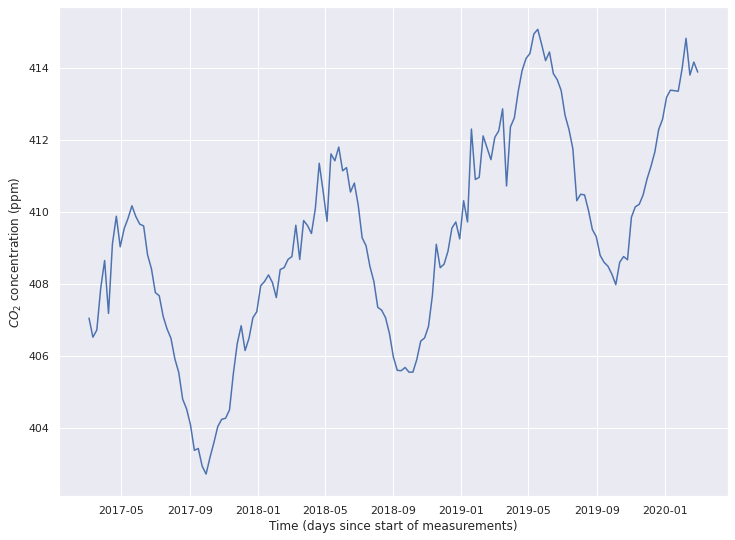

In [10]:
#Figure 3
plt.figure(figsize= (12,9))
plt.plot(climate['Date'][-156:], climate['co2'][-156:])
plt.xlabel('Time (days since start of measurements)')
plt.ylabel('$CO_2$ concentration (ppm)')



# Model 

### Sample

The model proposed by the assignment description is a combination of a linear trend over time and a cosine variation across a year and normally distributed noise distributed around zero with a fixed standard distribution. 

- Long-term trend: linear, $c_0 + c_1t$
- Seasonal variation (every 365¼ days): cosine, $c_2 cos(2  π  t / 365.25 + c_3)$
- Noise: Gaussian with mean 0 and fixed standard deviation, $c_4$
- The c_i variables are all unobserved parameters of the model.



Combining these three components gives the following likelihood function


$ p(x_t | \theta) = N(c_0 + c_1t + c_2cos(2 \pi t / 365.25 + c_3), c^2_4) $


where θ represents the set of all unobserved parameters. Since there are 3156 data, the full like
comprises a product overall 3156 values, x_t
. To complete the model we would still need to define
priors over all 5 model parameters.


### Linear Model

In [0]:
## Linear model
stan_code_linear = """
data {
    int<lower=0> n;        // lenght of the data set
    real days[n];           // day since start of record
    real co_2[n];             // The data
    
}

parameters {
    
    real c_0;               //constant c0
    real c_1;               //the linear coefficient c1
    
    real<lower=0, upper=2> A;        //amplitude 
    real<lower=0, upper =pi()> phase;             //phase
    
    real<lower=0> sigma;    // error (c4)

}


model {

    // using cauchy distributions because they are heavy tailed and we have a lot of uncertainty.
    c_0 ~ normal(310, 30); // the data has a start value around 310
    c_1 ~ cauchy(0,.01);
    
    A ~ cauchy(0, 5);
    phase ~ normal(0, 1);

    sigma ~ gamma(1, 2);
    for(t in 1:n) {
        co_2[t] ~ normal(c_0 + c_1*days[t] + 
            A * cos(2*pi()*days[t]/365.25 + phase),
            sigma);
    }
}

"""

In [12]:
stan_model_linear = pystan.StanModel(model_code=stan_code_linear)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e608b4ed678197d7b40ec602a07fafb7 NOW.


In [0]:
n = len(climate['Date'])

stan_data = {
    'n': n,
    'days': climate['Days'][:n],
    'co_2': climate['co2'][:n],
    
}


In [14]:
results = stan_model_linear.sampling(data=stan_data)
print(results.stansummary(pars= ['c_0', 'c_1', 'A', 'phase', 'sigma']))
samples = results.extract()

Inference for Stan model: anon_model_e608b4ed678197d7b40ec602a07fafb7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0   305.96  3.0e-3   0.15 305.68 305.86 305.96 306.06 306.25   2389    1.0
c_1   4.3e-3  2.2e-7 1.1e-5 4.3e-3 4.3e-3 4.3e-3 4.3e-3 4.3e-3   2601    1.0
A       1.98  6.3e-4   0.01   1.95   1.98   1.99    2.0    2.0    570    1.0
phase 4.3e-3  1.5e-4 4.2e-3 1.1e-4 1.2e-3 3.1e-3 6.1e-3   0.02    835   1.01
sigma   3.92  9.5e-4   0.05   3.83   3.89   3.92   3.95   4.02   2679    1.0

Samples were drawn using NUTS at Fri May  1 08:57:12 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [0]:
test = np.array([1,2,4,5,56,6,3,3,2,1])


### Checking for autocorrelation and irregularities in the sampling

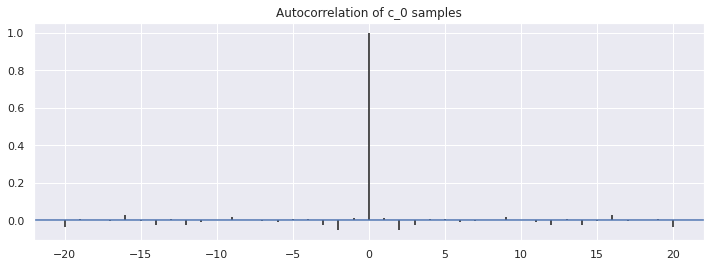

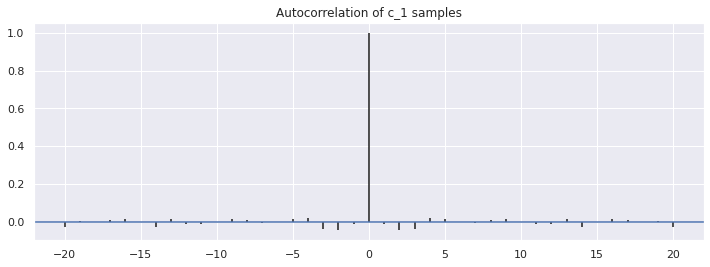

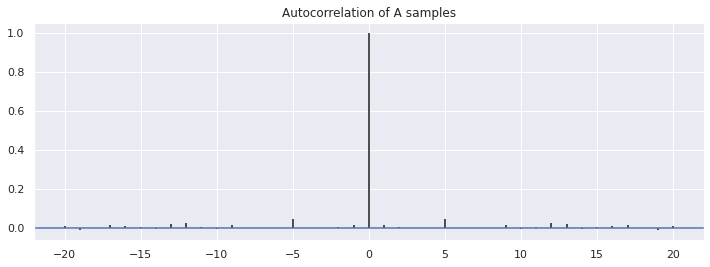

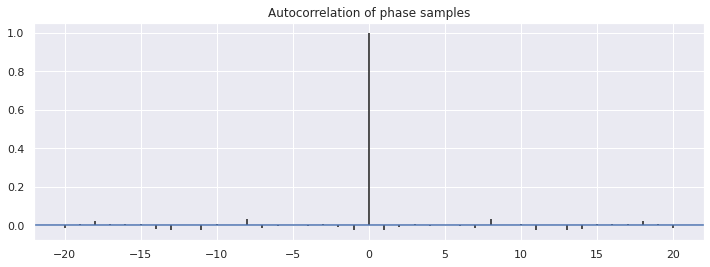

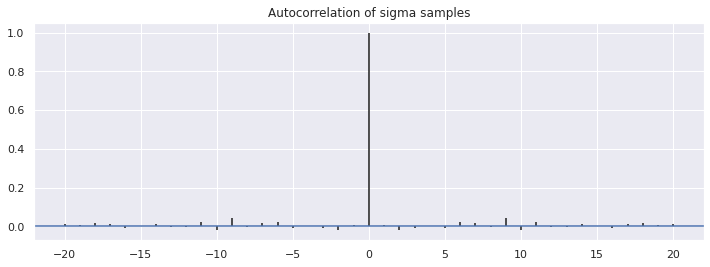

In [16]:
parameters = ['c_0', 'c_1', 'A', 'phase', 'sigma']
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

#plot the autocorrelation plots for the 5 parameters of the linear model
for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

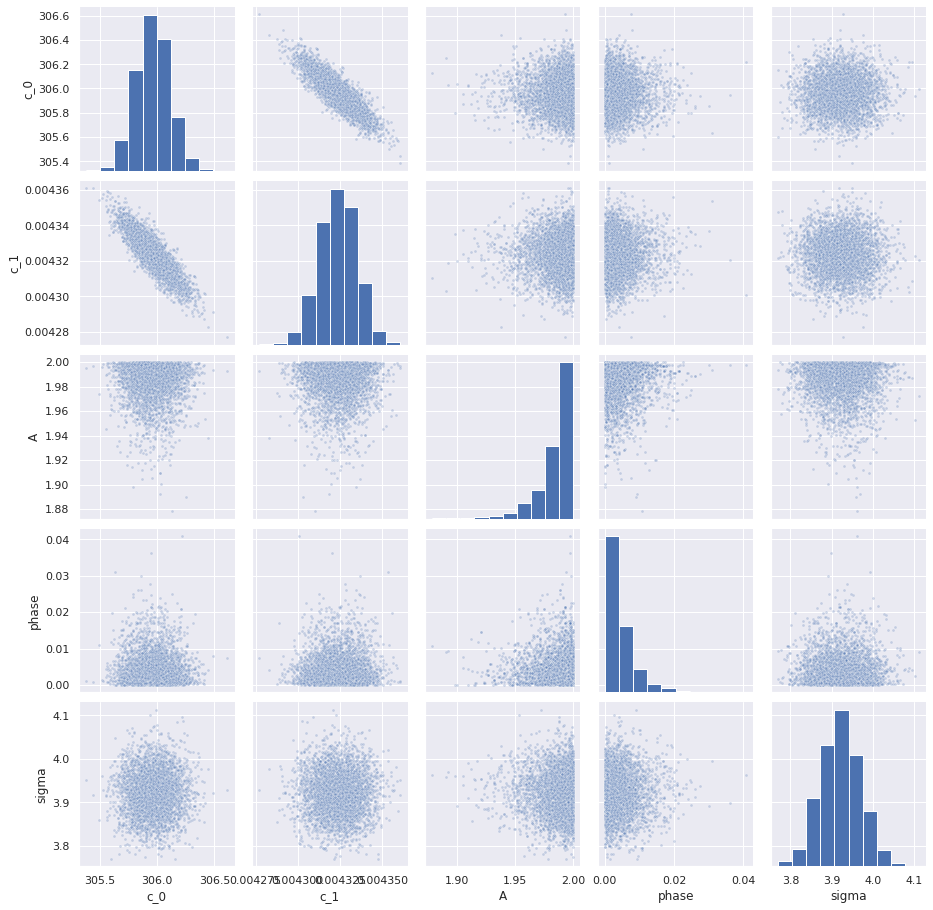

In [17]:
#plot the pairplots to check for irregularities

df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
sns.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

Looks good! 
Let's make some predictions and see how well we do.

In [0]:
def linear_predictions_confints(c_0, c_1, A, phase, sigma, start, end):

    """
    func: linear_predictions

    Inputs: the parameters samples from the linear model and how long to predict
    Output: upper, lower, and mean predicted for each week
    """


    lower = []
    upper = []
    means = []
   
    pred_days = []

    #calculate the ppm value for each recording already in the data
    for day in climate['Days']:

        week_prediction = []

        #get one set of the 4000 sampled parameters
        for i in range(1000):

            #calculate it with a set of estimated parameters
            week_prediction.append(sts.norm.rvs(c_0[i] + c_1[i]*day + 
            A[i] * np.cos(2*np.pi*day/365.25 + phase[i]),
            sigma[i]))

        #calculate the confidence interval and add results to list
        conf = np.percentile(week_prediction, (2.5, 97.5))
        means.append(np.mean(week_prediction))

        lower.append(conf[0])
        upper.append(conf[1])

        pred_days.append(day)

    last_day = day
   
    #do the above for projected dates in a weekly increment
    for day in range(last_day, end, 7):

        week_prediction = []

        for i in range(1000):
            
            #run through the predictions 
            week_prediction.append(sts.norm.rvs(c_0[i] + c_1[i]*day + 
            A[i] * np.cos(2*np.pi*day/365.25 + phase[i]),
            sigma[i]))

        conf = np.percentile(week_prediction, (2.5, 97.5))
        means.append(np.mean(week_prediction))

        lower.append(conf[0])
        upper.append(conf[1])

        pred_days.append(day)


    return [pred_days, means, upper, lower]

In [0]:
last_day_since = climate['Days'].max() + 365*40
predictions = linear_predictions_confints(samples['c_0'], samples['c_1'], samples['A'], samples['phase'],samples['sigma'], 0, last_day_since)

Text(0, 0.5, '$CO_2$ concentration (ppm)')

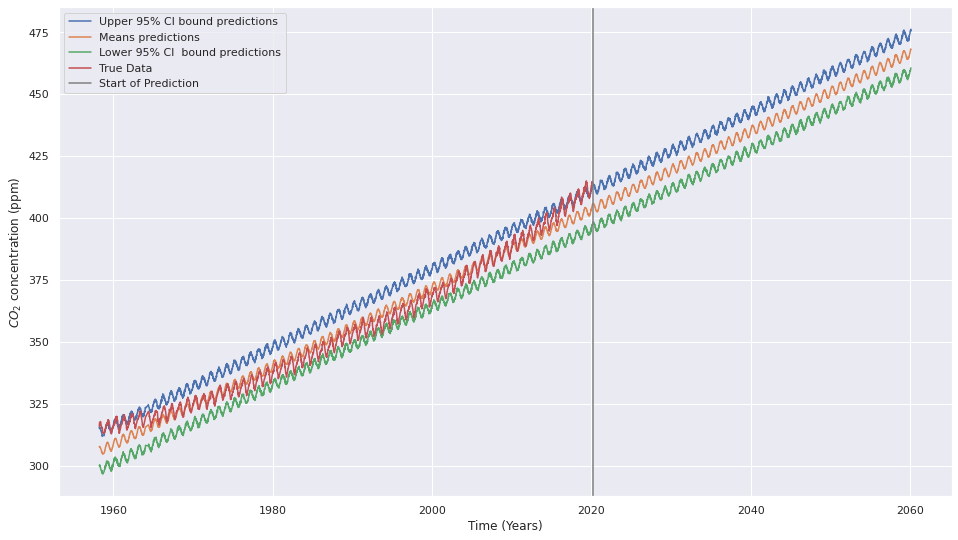

In [20]:
plt.figure(figsize= (16,9))
#convert back to datetime
pred_asdt = convert_back_to_datetime(predictions[0])

#Figure 4
plt.plot(pred_asdt, predictions[2], label = 'Upper 95% CI bound predictions')
plt.plot(pred_asdt, predictions[1], label = 'Means predictions')
plt.plot(pred_asdt, predictions[3], label = 'Lower 95% CI  bound predictions')
plt.plot(climate['Date'], climate['co2'], label = 'True Data')
plt.axvline(pred_asdt[len(climate['Days']) + 1], label = 'Start of Prediction', ls = '-', color = 'grey')
plt.legend()
plt.xlabel('Time (Years)')
plt.ylabel('$CO_2$ concentration (ppm)')

Plot the error

In [0]:
def mean_squared_error(target, approximation):

    a_target = np.asarray(target)
    a_approx = np.asarray(approximation)

    return np.mean((a_target - a_approx)**2)

R^2: 0.9807094427246775


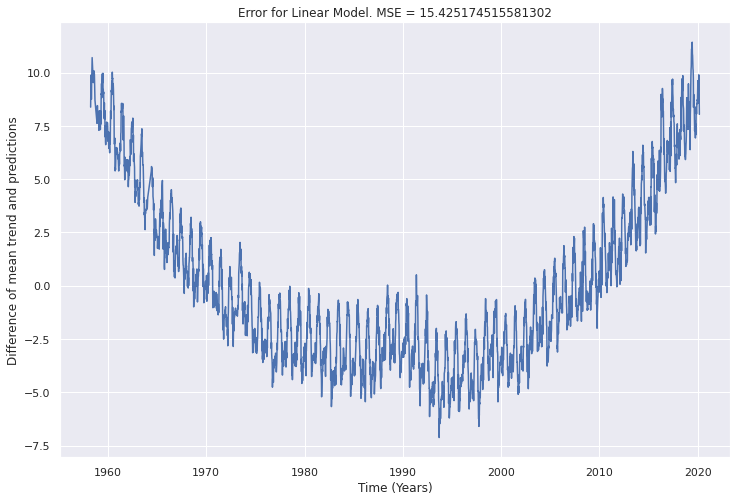

In [22]:
#Figure 5
plt.figure(figsize = (12,8))
plt.plot(climate['Date'], (np.asarray(climate['co2']) - np.asarray(predictions[1][:len(climate['Days'])])))
mse_linear = mean_squared_error(climate['co2'], predictions[1][:len(climate['Days'])])
plt.title(f'Error for Linear Model. MSE = {mse_linear}')
plt.xlabel('Time (Years)')
plt.ylabel('Difference of mean trend and predictions')
print('R^2:', sklearn.metrics.r2_score(climate['co2'], predictions[1][:len(climate['Days'])] ))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Text(0, 0.5, '$CO_2$ concentration (ppm)')

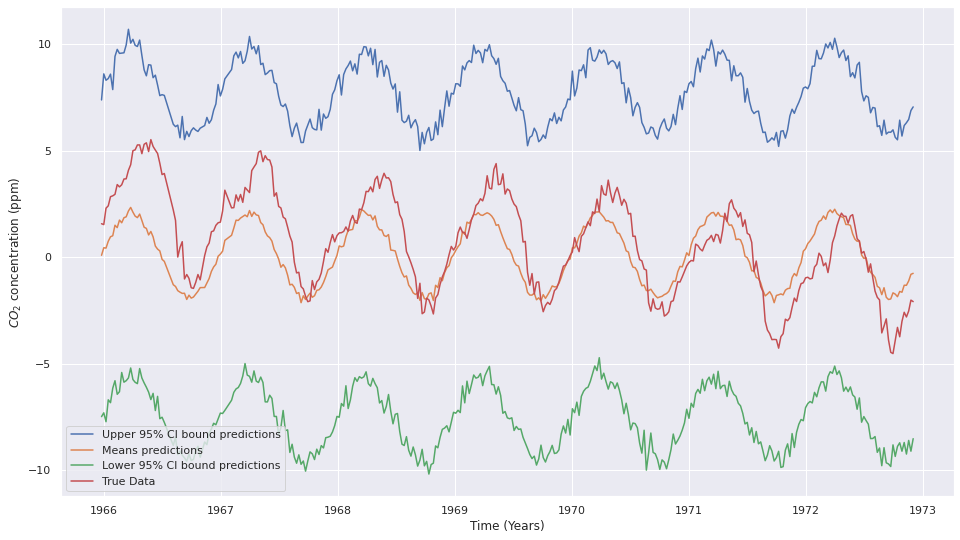

In [23]:
#figure 6
plt.figure(figsize= (16,9))
start = round(2500/7)
end = round(5000/7)
plt.plot(pred_asdt[start:end], predictions[2][start:end] - (np.array(predictions[0][start:end])*(4.3*10**-3) + 305.97), label = 'Upper 95% CI bound predictions')
plt.plot(pred_asdt[start:end], predictions[1][start:end]- (np.array(predictions[0][start:end])*(4.3*10**-3) + 305.97), label = 'Means predictions')
plt.plot(pred_asdt[start:end], predictions[3][start:end]- (np.array(predictions[0][start:end])*(4.3*10**-3) + 305.97), label = 'Lower 95% CI bound predictions')
plt.plot(climate['Date'][start:end], climate['co2'][start:end]- (np.array(predictions[0][start:end])*(4.3*10**-3) + 305.97), label = 'True Data')

plt.legend()
plt.xlabel('Time (Years)')
plt.ylabel('$CO_2$ concentration (ppm)')

In [0]:
#calculate the test statistic of my design.

def tilt_test(time, real_data, predictions):

    deltaT_min_max_REAL = []
    deltaT_min_max_PRED = []

    weeks_looked_at =[]
    co2_looked_at =[]

    #I am starting from 8 here since this allowed for the minimal shift in the data for there to be minimial number of cases where the min and max occurred in reverse order.
    #This occurs because there are not exactly 52 weeks in a year and as shown below, the min and max don't always occur at the same time during the year. 
    #By starting at the 8th week, I was able to only neglect 2 out of the 62 years means even if they were opposite the p-value comparison they would only change the p-value by 0.03.  
    for year in range(8, len(time), 52):

        #calculate the time difference in the max and min for one year

        #for the real data
        one_year = real_data[year:year+52]

        max_week =  np.argmax(one_year)
        min_week = np.argmin(one_year)
        
        
        dif =  max_week - min_week
        
        #exclude the hickups
        if dif < 0:
            print(f'Excluded {year/52}')
            continue
        
        
        weeks_looked_at.append(time[year + max_week])
        weeks_looked_at.append(time[year + min_week])

        co2_looked_at.append(real_data[year + max_week])
        co2_looked_at.append(real_data[year + min_week])

        
        #get the indices of min and max and their difference
        deltaT_min_max_REAL.append(dif)

        one_year_prediction = predictions[year:year+52]
        deltaT_min_max_PRED.append(np.argmax(one_year_prediction) - np.argmin(one_year_prediction))

    #calculate p-value
    p_value = np.mean(deltaT_min_max_REAL >= deltaT_min_max_PRED)

    return deltaT_min_max_REAL, deltaT_min_max_PRED, p_value,  weeks_looked_at, co2_looked_at




Excluded 4.153846153846154
Excluded 5.153846153846154


Text(0.5, 1.0, 'Difference between highest and lowest concentration in a one year timespan. \n Mean for the real data: 31.237 weeks. \n P-val: 1.0')

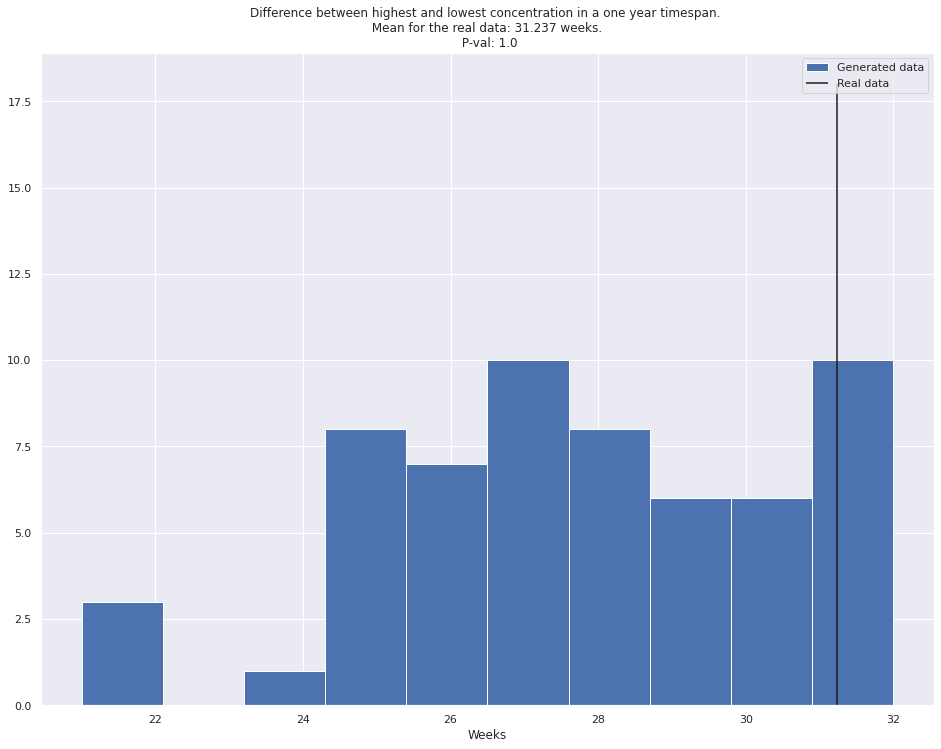

In [25]:
stat_test = tilt_test(climate['Date'], climate['co2'], predictions[1])

plt.figure(figsize=(16, 12))
plt.vlines(np.mean(stat_test[0]), ymin =0, ymax = 18, label = 'Real data')
plt.hist(stat_test[1], label = 'Generated data')
plt.title(('P-val:', stat_test[2]))
plt.xlabel('Weeks')
plt.legend()
plt.title(f'Difference between highest and lowest concentration in a one year timespan. \n Mean for the real data: {round(np.mean(stat_test[0]),3)} weeks. \n P-val: {stat_test[2]}')

59.0


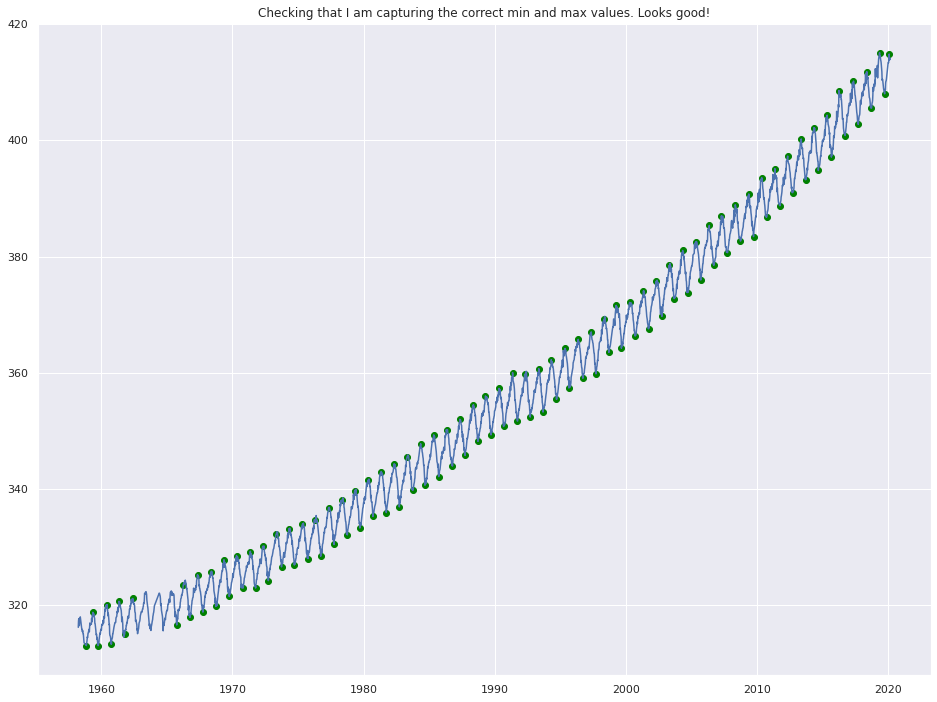

In [26]:
plt.figure(figsize=(16,12))
plt.plot(climate['Date'], climate['co2'])
plt.scatter(stat_test[3], stat_test[4], color = 'green')
plt.title('Checking that I am capturing the correct min and max values. Looks good!')
print(len(stat_test[4])/2)

### Quadratic Model

The quadratic model does better with the time being converted to years rather than days. 
Hence, we have to adjust some of the priors for the parameters a bit. They should be slightly higher because we have converted to a different scale. 

In [0]:
#convert to years since start
climate["year"] = ((pd.to_datetime(climate.Date) - pd.to_datetime(climate.Date[0])).dt.days) / 365.25


In [0]:
## quadratic model
stan_code_quad = """
data {
    int<lower=0> n;        // lenght of the data set
    real days[n];           // day since start of record
    real co_2[n];             // The data
}

parameters {
    
    real <lower = 0> c_0;               //constant c
    real c_1 ;               //the linear coefficient c1
    real c_2;               //the quadratic coefficient
    
    real <lower = 0, upper =2> A;
    real <lower = 0, upper =2> A_1;

    // We need a periodic phi
    real phi_x;
    real phi_y;
    
    
    real <lower=0> sigma;    // error (c4)

}

transformed parameters {
    real<lower=-pi(),upper=pi()> phi;

    // The atan2 function returns a value in the range [-pi, pi].
    phi = atan2(phi_x, phi_y);
}


model {

    // 
    c_0 ~ normal(310, 30); // the data has a start value around 310
    c_1 ~ normal(0,.01); 
    c_2 ~ normal(0,.01);

    //period ~ normal(1, .2); // really certain about the lenght of a year

    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    
    A ~ cauchy(1, 2);
    A_1 ~ cauchy(1, 2);
    
    sigma ~ normal(0,5);


    for(t in 1:n) {
        co_2[t] ~ normal(c_0 + 
                    c_1*days[t] + 
                    c_2*days[t]^2 + 
                    A * sin(2*pi()/1*days[t] + phi) + 
                    A_1 * sin(2*pi()/1*days[t] + phi),
                    sigma);
    }
}

"""

In [29]:
stan_model_quad = pystan.StanModel(model_code=stan_code_quad)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fd9bd565295129ed2f7a43e8d3f803f0 NOW.


In [30]:
#careful! this cell took around 3 hours to run
n = len(climate['year'])

stan_data_q = {
    'n': n,
    'days': climate["year"][:n],
    'co_2': climate['co2'][:n],
}
#extract the result. increasing the max_treedepth and adapt_delta for more robust sampling
results_quad = stan_model_quad.sampling(data=stan_data_q, control={'max_treedepth': 12, 'adapt_delta' : .98})
samples_quad = results_quad.extract()

In [31]:
print(results_quad.stansummary(pars= ['c_0', 'c_1','c_2','A','A_1', 'phi', 'sigma']))

Inference for Stan model: anon_model_fd9bd565295129ed2f7a43e8d3f803f0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0   316.27  1.9e-3   0.08 316.12 316.21 316.27 316.32 316.41   1690    1.0
c_1     0.63  1.5e-4 5.9e-3   0.61   0.62   0.63   0.63   0.64   1534    1.0
c_2     0.02  2.3e-6 9.0e-5   0.01   0.02   0.02   0.02   0.02   1576    1.0
A       1.41    0.01   0.33   0.87   1.12   1.41    1.7   1.98    975    1.0
A_1     1.44    0.01   0.33   0.88   1.16   1.45   1.73   1.97    976    1.0
phi     1.16  1.6e-4   0.01   1.14   1.15   1.16   1.17   1.18   4288    1.0
sigma   1.17  4.9e-4   0.02   1.13   1.15   1.17   1.18    1.2   1631    1.0

Samples were drawn using NUTS at Fri May  1 11:06:23 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

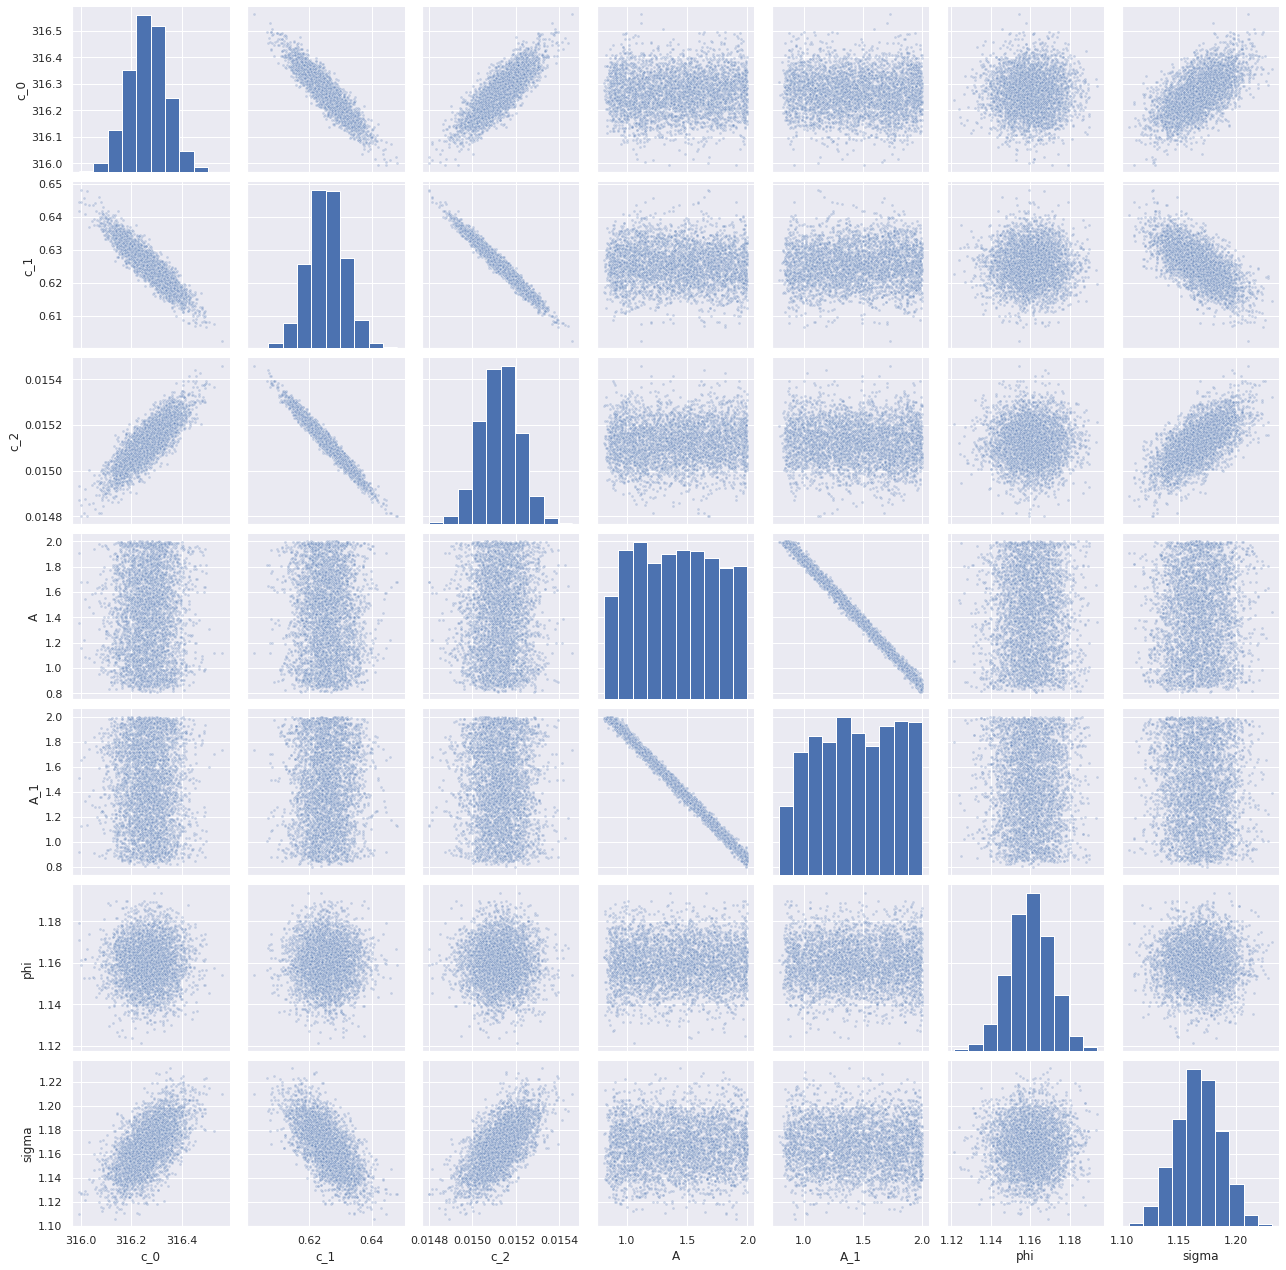

In [32]:
params_exp =['c_0', 'c_1','c_2','A','A_1', 'phi', 'sigma']
df = pd.DataFrame(
    data=np.transpose([samples_quad[param] for param in params_exp]),
    columns=params_exp)
sns.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [0]:
def doublesin_predictions_confints(c_0, c_1, c_2, A, A_1, phase, sigma, start, end):

    """
    func: doublesin_predictions_confints

    Inputs: the parameters samples from the linear model and how long to predict
    Output: upper, lower, and mean predicted for each week
    """

    all_replicates = []

    lower = []
    upper = []
    means = []
   
    pred_days = []


    #iterate through the dates in the dataset
    for day in climate['year']:

        week_prediction = []

        #pick a set of parameters from those in the sample
        for i in range(1000):

            #calculate the ppm value
            week_prediction.append(sts.norm.rvs(c_0[i] + 
                                                c_1[i]*day + 
                                                c_2[i]*day**2 +
                                                A[i] * np.sin(2*np.pi*day + phase[i]) + 
                                                A_1[i] * np.sin(2*np.pi*day + phase[i]),
                                                sigma[i]))


        #record the results and the CI interval
        all_replicates.append(all_replicates)
        conf = np.percentile(week_prediction, (2.5, 97.5))
        means.append(np.mean(week_prediction))

        lower.append(conf[0])
        upper.append(conf[1])

        pred_days.append(day)

    last_day = day
   
    
    for day in range(0, end, 1):

        #iterate through the 40 weeks we are predicting
        x = last_day + (day/52.14)

        week_prediction = []

        #pick a set of parameters
        for i in range(1000):
            
            #calculate the predicted value
            week_prediction.append(sts.norm.rvs(c_0[i] + 
                                                c_1[i]*x + 
                                                c_2[i]*x**2 +
                                                A[i] * np.sin(2*np.pi*x + phase[i]) + 
                                                A_1[i] * np.sin(2*np.pi*x + phase[i]),
                                                sigma[i]))

        #calculate confidence intervals and record results
        conf = np.percentile(week_prediction, (2.5, 97.5))
        means.append(np.mean(week_prediction))

        lower.append(conf[0])
        upper.append(conf[1])

        pred_days.append(x)


    return [pred_days, means, upper, lower, all_replicates]

In [0]:
last_day_since = round(climate['year'].max()) + 40*52

predictions_quad = doublesin_predictions_confints(c_0 = samples_quad['c_0'], c_1= samples_quad['c_1'],c_2 = samples_quad['c_2'], A = samples_quad['A'], A_1 =  samples_quad['A_1'], phase = samples_quad['phi'], sigma = samples_quad['sigma'], start = 0, end = last_day_since)

In [0]:
#converting back from the day scale 
def convert_back_to_datetime_from_years(array):
    actual_dates = []

    for day in array:
        #add the original date back onto it
        
        actual_dates.append(climate['Date'][0] + datetime.timedelta(day))
    return actual_dates

Text(0, 0.5, '$CO_2$ concentration (ppm)')

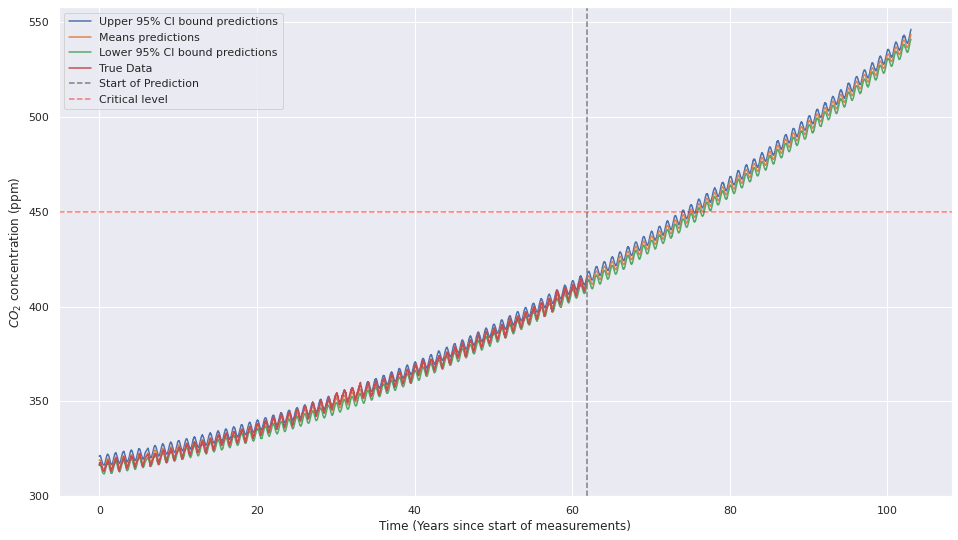

In [36]:
plt.figure(figsize= (16,9))
#figure 9
plt.plot(predictions_quad[0], predictions_quad[2], label = 'Upper 95% CI bound predictions')
plt.plot(predictions_quad[0], predictions_quad[1], label = 'Means predictions')
plt.plot(predictions_quad[0], predictions_quad[3], label = 'Lower 95% CI bound predictions')
plt.plot(climate['year'], climate['co2'], label = 'True Data')
plt.axvline(predictions_quad[0][len(climate['Days']) + 1], label = 'Start of Prediction', ls = '--', color = 'grey')
plt.axhline(y = 450, ls = '--', color = 'red', label = 'Critical level', alpha= .5)
plt.legend()
plt.xlabel('Time (Years since start of measurements)')
plt.ylabel('$CO_2$ concentration (ppm)')

Text(0, 0.5, '$CO_2$ concentration (ppm)')

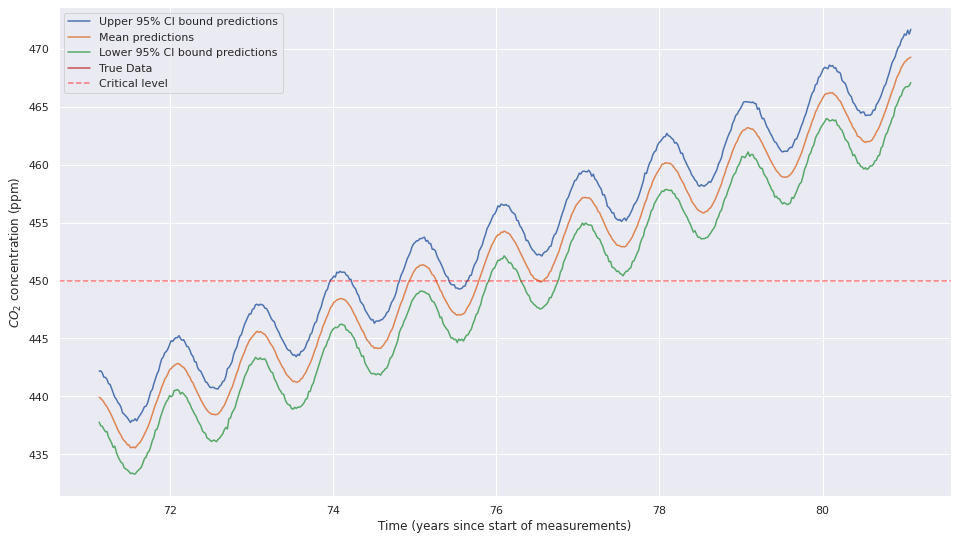

In [37]:
plt.figure(figsize= (16,9))
## change start end to produce figures 10 and 11
start = round(70*52)
end = round(80*52)
plt.plot(predictions_quad[0][start:end], predictions_quad[2][start:end], label = 'Upper 95% CI bound predictions')
plt.plot(predictions_quad[0][start:end], predictions_quad[1][start:end], label = 'Mean predictions')
plt.plot(predictions_quad[0][start:end], predictions_quad[3][start:end], label = 'Lower 95% CI bound predictions')
plt.plot(climate['year'][start:end], climate['co2'][start:end], label = 'True Data')
#plt.axvline(predictions_quad[0][len(climate['Days']) + 1], label = 'Start of Prediction', ls = '--', color = 'grey')
plt.axhline(y = 450, ls = '--', color = 'red', label = 'Critical level', alpha= .5)
plt.legend()
plt.xlabel('Time (years since start of measurements)')
plt.ylabel('$CO_2$ concentration (ppm)')

Text(0.5, 0, 'Time (years since first observation)')

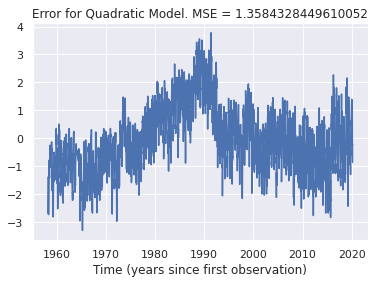

In [38]:
plt.plot(climate['Date'], (np.asarray(climate['co2']) - np.asarray(predictions_quad[1][:len(climate['Days'])])))
mse_doublesin = mean_squared_error(climate['co2'], predictions_quad[1][:len(climate['Days'])])
plt.title(f'Error for Quadratic Model. MSE = {mse_doublesin}')
plt.xlabel('Time (years since first observation)')

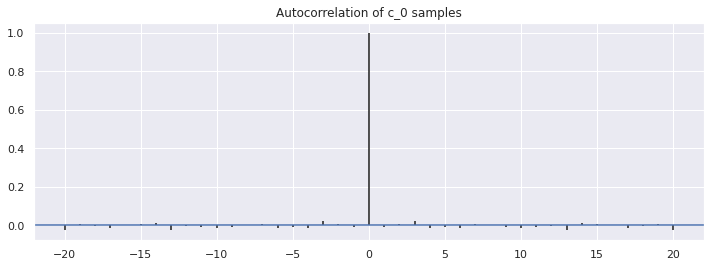

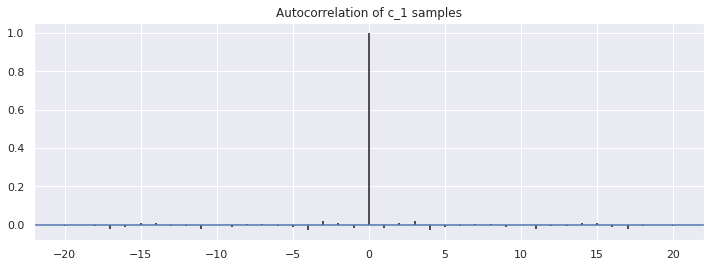

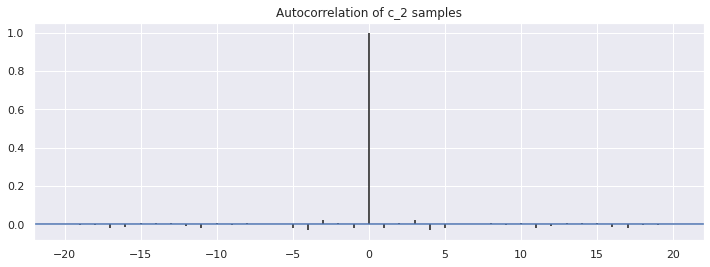

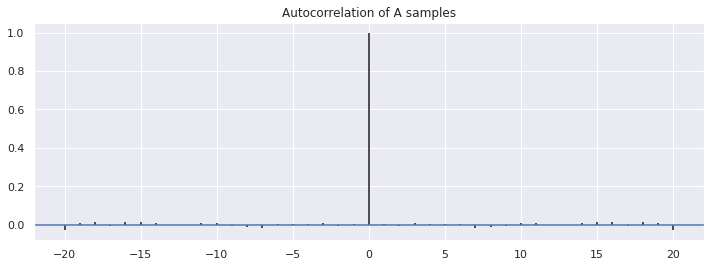

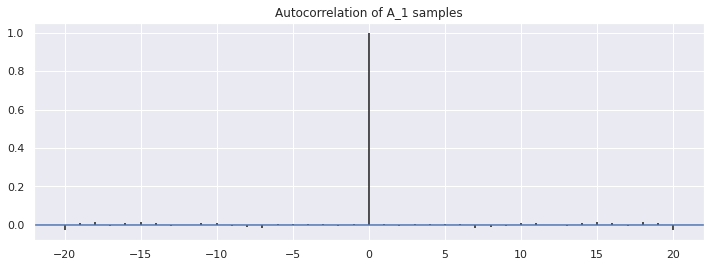

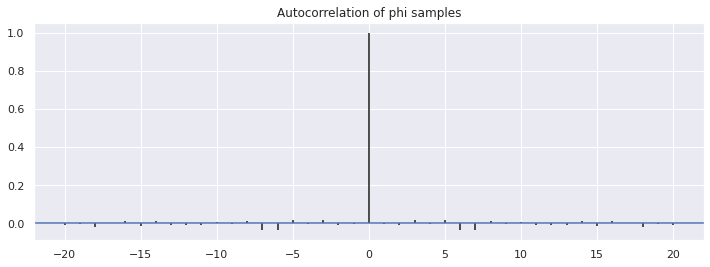

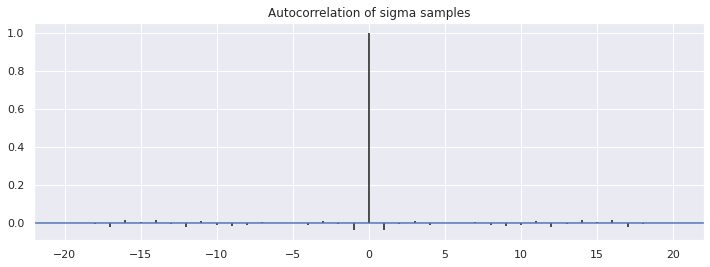

In [39]:

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

#plot the autocorrelation plots for the 5 parameters of the linear model
for param in params_exp:
    plt.figure(figsize=(12, 4))
    plot_acf(samples_quad[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

Excluded 4.153846153846154
Excluded 5.153846153846154


Text(0.5, 1.0, 'Difference between highest and lowest concentration in a one year timespan. \n Mean for the real data: 31.237 weeks. \n P-val: 1.0')

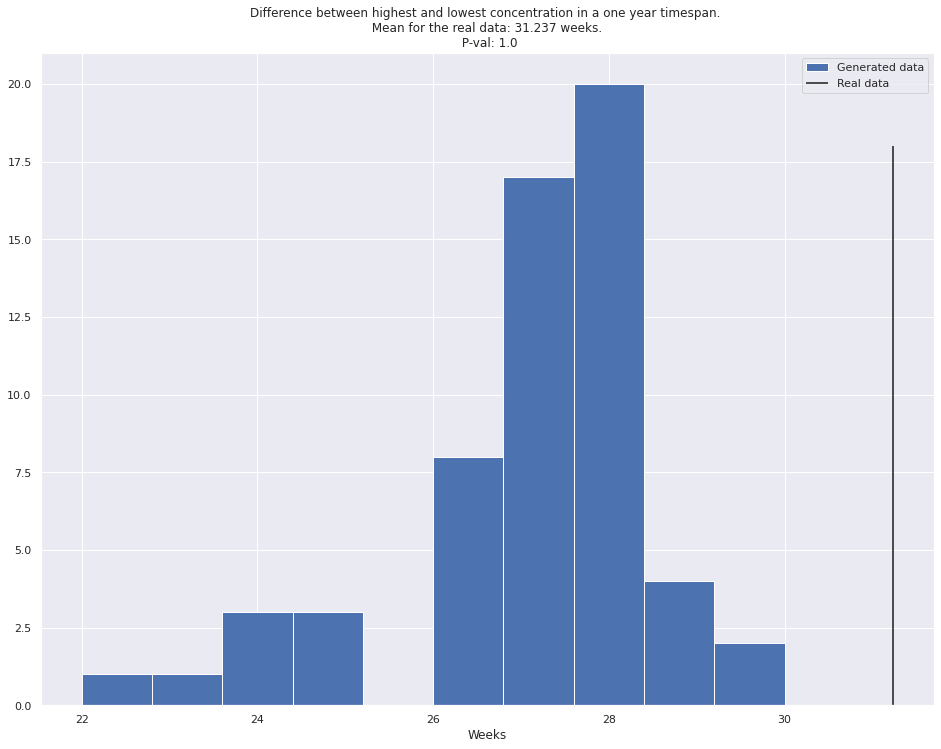

In [40]:
stat_test = tilt_test(climate['Date'], climate['co2'], predictions_quad[1])

plt.figure(figsize=(16, 12))
plt.vlines(np.mean(stat_test[0]), ymin =0, ymax = 18, label = 'Real data')
plt.hist(stat_test[1], label = 'Generated data')
plt.title(('P-val:', stat_test[2]))
plt.xlabel('Weeks')
plt.legend()
plt.title(f'Difference between highest and lowest concentration in a one year timespan. \n Mean for the real data: {round(np.mean(stat_test[0]),3)} weeks. \n P-val: {stat_test[2]}')

In [41]:
critical_mean = datetime.timedelta(int(round(predictions_quad[0][(np.argmax(np.array(predictions_quad[1]) >= 450))]*365.25))) + climate['Date'][0] 
critical_5 = datetime.timedelta(int(round(predictions_quad[0][(np.argmax(np.array(predictions_quad[3]) >= 450))]*365.25))) + climate['Date'][0] 
critical_95 = datetime.timedelta(int(round(predictions_quad[0][(np.argmax(np.array(predictions_quad[2]) >= 450))]*365.25))) + climate['Date'][0] 

print(f'We will reach the critical point sometime between {critical_5} and {critical_95} but most likely at {critical_mean}')

We will reach the critical point sometime between 2034-03-01 00:00:00 and 2032-03-16 00:00:00 but most likely at 2033-03-09 00:00:00


In [0]:
def plot_hist(real, generated, name, p_val):

    plt.figure()
    plt.hist(generated, label = 'Generated data')
    plt.axvline(x = real, label = f'Real data: {real}')
    plt.title((f"{name} with P-value: {p_val}")) 
    plt.legend()

Text(0.5, 0, 'Error')

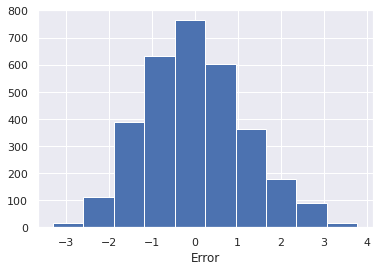

In [43]:
plt.hist((np.asarray(climate['co2']) - np.asarray(predictions_quad[1][:len(climate['Days'])])))
plt.xlabel('Error')

In [46]:
half_trend = datetime.timedelta(101.07492242668086*365.25) + climate['Date'][0] 
print(half_trend)

2059-04-25 14:46:11.972224
